In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from import_data import get_demand, get_gen, get_mcp, get_vre, read_processed_files
from environment import market_env
from actor_critic import ActorCriticAgent
from utils import plot_learning_curve
import numpy as np

# Get Data

In [5]:
df_demand, df_demand_scaled, df_vre, df_vre_scaled, df_gen, df_gen_scaled, df_mcp = read_processed_files()

In [17]:
# Example usage
env = market_env(demand=df_demand_scaled, re=df_vre_scaled, prices=df_mcp, eps_length=24, capacity=200, mc=30)

# Assuming you have a gym environment called 'env'
input_size = env.observation_space.shape[0]
n_actions = env.action_space.n
n_games = 1000

agent = ActorCriticAgent(input_size, n_actions)

filename = 'power_plant.png'

figure_file = 'plots/' + filename

best_score = env.reward_range[0]
score_history = []
load_checkpoint = False

/Users/louis.skowronek/miniforge3/envs/bda_env/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [18]:
reward_history = []

if load_checkpoint:
    agent.load_models()

for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0


    while not done:

        action = agent.choose_action(observation)

        observation_next, reward, done, _ = env.step(action)
        score += reward
        if not load_checkpoint:
            agent.update(observation, reward, observation_next, done)
        observation = observation_next

    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        if not load_checkpoint:
            agent.save_models()

    print('episode ', i, 'score %.1f' % score, 'avg_score %.1f' % avg_score)

... saving models ...
episode  0 score 28.8 avg_score 28.8
episode  1 score 8.2 avg_score 18.5
episode  2 score 15.4 avg_score 17.5
episode  3 score 8.9 avg_score 15.3
episode  4 score 38.9 avg_score 20.0
episode  5 score 16.4 avg_score 19.4
episode  6 score 14.8 avg_score 18.8
episode  7 score 65.4 avg_score 24.6
... saving models ...
episode  8 score 161.8 avg_score 39.8
... saving models ...
episode  9 score 77.2 avg_score 43.6
... saving models ...
episode  10 score 50.1 avg_score 44.2
episode  11 score 7.3 avg_score 41.1
... saving models ...
episode  12 score 92.2 avg_score 45.0
episode  13 score 41.8 avg_score 44.8
... saving models ...
episode  14 score 168.6 avg_score 53.1
episode  15 score 43.3 avg_score 52.4
... saving models ...
episode  16 score 115.6 avg_score 56.2
episode  17 score 8.5 avg_score 53.5
episode  18 score 86.9 avg_score 55.3
... saving models ...
episode  19 score 265.5 avg_score 65.8
... saving models ...
episode  20 score 138.5 avg_score 69.2
... saving mo

In [19]:
env.results_ep.describe()

,reward,market price,bid price,bid volume
count,18336.000000,18336.000000,18336.000000,18336.0
mean,7.130496,97.223395,33.787304,200.0
std,3.793304,108.177987,27.562829,0.0
min,-6.333300,-90.010000,0.000000,200.0
25%,6.709900,35.150000,30.000000,200.0
50%,8.402900,53.070000,30.000000,200.0
75%,9.760950,117.992500,30.000000,200.0
max,12.007600,850.000000,294.000000,200.0


In [20]:
env.results_ep

,reward,market price,bid price,bid volume
2021-09-12 00:00:00+02:00,0.0000,105.05,294.0,200.0
2021-09-12 01:00:00+02:00,0.0000,99.17,156.0,200.0
2021-09-12 02:00:00+02:00,0.0000,99.02,282.0,200.0
2021-09-12 03:00:00+02:00,0.0000,95.38,246.0,200.0
2021-09-12 04:00:00+02:00,0.0000,97.57,132.0,200.0
...,...,...,...,...
2019-03-29 19:00:00+01:00,8.2602,49.33,30.0,200.0
2019-03-29 20:00:00+01:00,8.1856,47.94,30.0,200.0
2019-03-29 21:00:00+01:00,7.8667,43.04,30.0,200.0
2019-03-29 22:00:00+01:00,7.8442,42.75,30.0,200.0


<Axes: >

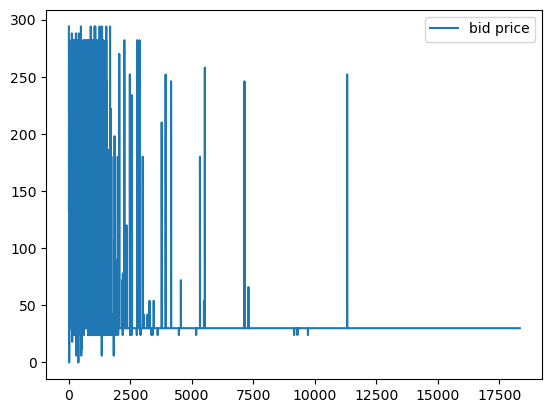

In [21]:
env.results_ep.reset_index().plot(y=['bid price'])

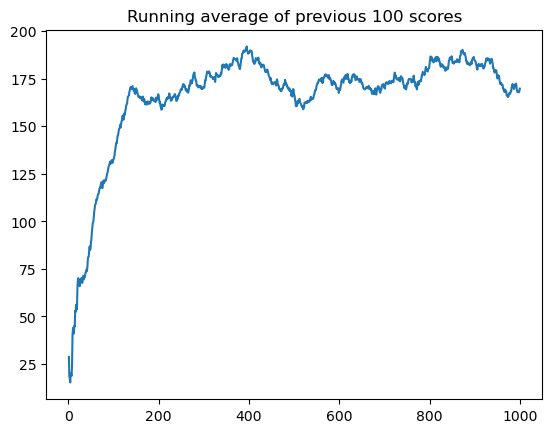

In [22]:
x = [i + 1 for i in range(len(score_history))]
plot_learning_curve(x, score_history)

In [3]:
import gym
from gym.spaces import Box, Discrete

# New Tests

In [10]:
from entsoe import EntsoePandasClient
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from import_data import aggregate_hourly, drop_incomplete_datapoints

In [163]:
# your_key = '9ab2e188-d454-44be-bce7-ea9dc8863723'
your_key = '3a72c137-c318-4dd5-ac00-2d3be87966a8'

country_code = 'DE_LU'  # Germany-Luxembourg

client = EntsoePandasClient(api_key=your_key)

In [164]:
start = pd.Timestamp(year=2022, month=1, day=1, tz="europe/brussels")
end = pd.Timestamp.now(tz="europe/brussels").floor('D') + pd.Timedelta(days=2)

# make api call
df_re_prog = pd.DataFrame(client.query_wind_and_solar_forecast(country_code, start=start, end=end, psr_type=None))

# rename columns
df_re_prog.columns = ['Forecasted Solar [MWh]', 'Forecasted Wind Offshore [MWh]', 'Forecasted Wind Onshore [MWh]']

# 15 min candles? -> aggregate hourly
df_re_prog = aggregate_hourly(df_re_prog)

# drop days with incomplete number of observations (!=24) per day. -> leap years
df_re_prog = drop_incomplete_datapoints(df_re_prog)

In [172]:
forecast_solar = df_re_prog[['Forecasted Solar [MWh]']].copy()

In [173]:
daily_total_solar_energy = forecast_solar.groupby([forecast_solar.index.date]).sum()

In [174]:
daily_total_solar_energy = forecast_solar.groupby([forecast_solar.index.date]).sum()
# set index to a datetime index
daily_total_solar_energy.index = pd.to_datetime(daily_total_solar_energy.index)

In [178]:
forecast_solar['day'] = forecast_solar.apply(lambda x: x.index.date)

In [180]:
daily_total_solar_energy

,Forecasted Solar [MWh]
2022-01-01,130566.0
2022-01-02,94954.0
2022-01-03,102006.0
2022-01-04,43926.0
2022-01-05,110089.0
...,...
2023-06-04,1448283.0
2023-06-05,1336448.0
2023-06-06,1070144.0
2023-06-07,1113397.0


In [179]:
forecast_solar

,Forecasted Solar [MWh],day
2022-01-01 00:00:00+01:00,0.0,2022-01-01
2022-01-01 01:00:00+01:00,0.0,2022-01-01
2022-01-01 02:00:00+01:00,0.0,2022-01-01
2022-01-01 03:00:00+01:00,0.0,2022-01-01
2022-01-01 04:00:00+01:00,0.0,2022-01-01
...,...,...
2023-06-08 19:00:00+02:00,21169.0,2023-06-08
2023-06-08 20:00:00+02:00,6610.0,2023-06-08
2023-06-08 21:00:00+02:00,594.0,2023-06-08
2023-06-08 22:00:00+02:00,12.0,2023-06-08


In [ ]:
daily_total_solar_energy = forecast_solar.groupby([forecast_solar.index.date]).sum()
# set index to a datetime index
daily_total_solar_energy.index = pd.to_datetime(daily_total_solar_energy.index)

forecast_solar['forecast_day']=forecast_solar.apply(lambda x: x.index.date)
forecast_solar['forecast_day'] = pd.to_datetime(forecast_solar['forecast_day'])

In [ ]:
df_demand_scaled

In [181]:
scaler = MinMaxScaler((0,1))
forecast_solar = df_re_prog['Forecasted Solar [MWh]'].copy()
forecast_solar.groupby(lambda x: scaler.fit_transform(x['Forecasted Solar [MWh]'].values))

In [186]:
# Group the data by day and apply scaling to each day's values
df_re_prog['scaled_solar'] = df_re_prog.groupby(df_re_prog.index.date)['Forecasted Solar [MWh]'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())

In [150]:


# calculate total energy per day
daily_total_solar_energy = forecast_solar.groupby([forecast_solar.index.date]).sum()
# set index to a datetime index
daily_total_solar_energy.index = pd.to_datetime(daily_total_solar_energy.index)

forecast_solar['forecast_day']=forecast_solar.apply(lambda x: x.index.date)
forecast_solar['forecast_day'] = pd.to_datetime(forecast_solar['forecast_day'])

In [152]:
daily_total_solar_energy

,Forecasted Solar [MWh]
2022-01-01,130566.0
2022-01-02,94954.0
2022-01-03,102006.0
2022-01-04,43926.0
2022-01-05,110089.0
...,...
2023-06-04,1448283.0
2023-06-05,1336448.0
2023-06-06,1070144.0
2023-06-07,1113397.0


In [119]:
daily_total_solar_energy[forecast_solar.index.date[0]]

In [140]:
daily_total_solar_energy

,Forecasted Solar [MWh]
2022-01-01,130566.0
2022-01-02,94954.0
2022-01-03,102006.0
2022-01-04,43926.0
2022-01-05,110089.0
...,...
2023-06-04,1448283.0
2023-06-05,1336448.0
2023-06-06,1070144.0
2023-06-07,1113397.0


In [148]:
daily_total_solar_energy[forecast_solar.index.date[0]]

KeyError: Timestamp('2022-01-01 00:00:00')

In [146]:
daily_total_solar_energy

pandas._libs.tslibs.timestamps.Timestamp

In [129]:
forecast_solar['forecast_day'].map(lambda x: daily_total_solar_energy[x])

KeyError: 'forecast_day'

In [130]:
daily_total_solar_energy[pd.Timestamp()]

TypeError: function missing required argument 'year' (pos 1)

In [110]:
daily_total_solar_energy['2022-01-01']

KeyError: '2022-01-01'

In [94]:
# Calculate the relative value of solar energy for each hour
forecast_solar['relative_value'] = forecast_solar['Forecasted Solar [MWh]'] / forecast_solar.index.map(lambda x: daily_total_solar_energy[x.date()])

KeyError: datetime.date(2022, 1, 1)

In [92]:
forecast_solar.index

DatetimeIndex(['2022-01-01 00:00:00+01:00', '2022-01-01 01:00:00+01:00',
               '2022-01-01 02:00:00+01:00', '2022-01-01 03:00:00+01:00',
               '2022-01-01 04:00:00+01:00', '2022-01-01 05:00:00+01:00',
               '2022-01-01 06:00:00+01:00', '2022-01-01 07:00:00+01:00',
               '2022-01-01 08:00:00+01:00', '2022-01-01 09:00:00+01:00',
               ...
               '2023-06-08 14:00:00+02:00', '2023-06-08 15:00:00+02:00',
               '2023-06-08 16:00:00+02:00', '2023-06-08 17:00:00+02:00',
               '2023-06-08 18:00:00+02:00', '2023-06-08 19:00:00+02:00',
               '2023-06-08 20:00:00+02:00', '2023-06-08 21:00:00+02:00',
               '2023-06-08 22:00:00+02:00', '2023-06-08 23:00:00+02:00'],
              dtype='datetime64[ns, Europe/Berlin]', length=12504, freq=None)

In [93]:
forecast_solar.apply(lambda x: daily_total_solar_energy.loc[x.index.date])

ValueError: If using all scalar values, you must pass an index

In [89]:
daily_total_solar_energy

,Forecasted Solar [MWh]
2022-01-01,130566.0
2022-01-02,94954.0
2022-01-03,102006.0
2022-01-04,43926.0
2022-01-05,110089.0
...,...
2023-06-04,1448283.0
2023-06-05,1336448.0
2023-06-06,1070144.0
2023-06-07,1113397.0


,Forecasted Solar [MWh]
2022-01-01,130566.0
2022-01-02,94954.0
2022-01-03,102006.0
2022-01-04,43926.0
2022-01-05,110089.0
...,...
2023-06-04,1448283.0
2023-06-05,1336448.0
2023-06-06,1070144.0
2023-06-07,1113397.0


In [96]:
forecast_solar['forecast_day']=forecast_solar.apply(lambda x: x.index.date)

In [76]:
daily_total_solar_energy.loc[pd.Timestamp(forecast_solar.iloc[[0]].index[0].date())]

Forecasted Solar [MWh]    130566.0
Name: 2022-01-01 00:00:00, dtype: float64

In [62]:
daily_total_solar_energy.index

DatetimeIndex(['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10',
               ...
               '2023-05-30', '2023-05-31', '2023-06-01', '2023-06-02',
               '2023-06-03', '2023-06-04', '2023-06-05', '2023-06-06',
               '2023-06-07', '2023-06-08'],
              dtype='datetime64[ns]', length=521, freq=None)

In [55]:
forecast_solar.index

DatetimeIndex(['2022-01-01 00:00:00+01:00', '2022-01-01 01:00:00+01:00',
               '2022-01-01 02:00:00+01:00', '2022-01-01 03:00:00+01:00',
               '2022-01-01 04:00:00+01:00', '2022-01-01 05:00:00+01:00',
               '2022-01-01 06:00:00+01:00', '2022-01-01 07:00:00+01:00',
               '2022-01-01 08:00:00+01:00', '2022-01-01 09:00:00+01:00',
               ...
               '2023-06-08 14:00:00+02:00', '2023-06-08 15:00:00+02:00',
               '2023-06-08 16:00:00+02:00', '2023-06-08 17:00:00+02:00',
               '2023-06-08 18:00:00+02:00', '2023-06-08 19:00:00+02:00',
               '2023-06-08 20:00:00+02:00', '2023-06-08 21:00:00+02:00',
               '2023-06-08 22:00:00+02:00', '2023-06-08 23:00:00+02:00'],
              dtype='datetime64[ns, Europe/Berlin]', length=12504, freq=None)

In [54]:
daily_total_solar_energy.index

DatetimeIndex(['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10',
               ...
               '2023-05-30', '2023-05-31', '2023-06-01', '2023-06-02',
               '2023-06-03', '2023-06-04', '2023-06-05', '2023-06-06',
               '2023-06-07', '2023-06-08'],
              dtype='datetime64[ns]', length=521, freq=None)

In [52]:
daily_total_solar_energy.index[0]

Timestamp('2022-01-01 00:00:00')

In [30]:
forecast_solar.index.map(lambda x: daily_total_solar_energy[x.date()])

KeyError: datetime.date(2022, 1, 1)

In [20]:
df_re_prog.groupby([pd.Grouper(freq='1d')]).sum()

,Forecasted Solar [MWh],Forecasted Wind Offshore [MWh],Forecasted Wind Onshore [MWh]
2022-01-01 00:00:00+01:00,130566.0,491021.0,1486969.0
2022-01-02 00:00:00+01:00,94954.0,556874.0,2463120.0
2022-01-03 00:00:00+01:00,102006.0,588415.0,3092386.0
2022-01-04 00:00:00+01:00,43926.0,366535.0,1336172.0
2022-01-05 00:00:00+01:00,110089.0,608893.0,2748791.0
...,...,...,...
2023-06-04 00:00:00+02:00,1448283.0,31482.0,472973.0
2023-06-05 00:00:00+02:00,1336448.0,24066.0,448020.0
2023-06-06 00:00:00+02:00,1070144.0,88763.0,457983.0
2023-06-07 00:00:00+02:00,1113397.0,84047.0,295999.0


In [18]:
forecast_solar.groupby()

,Forecasted Solar [MWh]
2022-01-01 00:00:00+01:00,0.0
2022-01-01 01:00:00+01:00,0.0
2022-01-01 02:00:00+01:00,0.0
2022-01-01 03:00:00+01:00,0.0
2022-01-01 04:00:00+01:00,0.0
...,...
2023-06-08 19:00:00+02:00,21169.0
2023-06-08 20:00:00+02:00,6610.0
2023-06-08 21:00:00+02:00,594.0
2023-06-08 22:00:00+02:00,12.0
